# Imports

In [1]:
import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import defaultdict
import itertools
import numpy as np

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn import metrics, naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble, model_selection
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from wordcloud import WordCloud ,STOPWORDS
import seaborn as sns

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
stop_words_en = stopwords.words('english')
stop_words_es = stopwords.words('spanish')

import spacy
es_nlp = spacy.load('es_core_news_sm')
en_nlp = spacy.load('en_core_web_sm')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Data Loading Functions

In [2]:
"""
Loading the data   --- these functions are taken and modified from ashraf2019
"""


def iter_docs(author):
    author_attr = author.attrib
    doc_dict = author_attr.copy()
    doc_dict['text'] = [' '.join([doc.text for doc in author.iter('document')])]
    return doc_dict


def create_test_data_frame(input_folder):
    # os.chdir(input_folder)
    os.chdir(input_folder)
    all_xml_files = glob.glob("*.xml")
    truth_data = pd.read_csv('truth.txt', sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    temp_list_of_DataFrames = []
    text_Data = pd.DataFrame()
    for file in all_xml_files:
        etree = ET.parse(file)  # create an ElementTree object
        doc_df = pd.DataFrame(iter_docs(etree.getroot()))
        doc_df['author_id'] = file[:-4]
        temp_list_of_DataFrames.append(doc_df)
    text_Data = pd.concat(temp_list_of_DataFrames, axis=0)

    data = text_Data.merge(truth_data, on='author_id')
    return data


def create_training_data_frame(input_folder, taining_div, testing_div):
    os.chdir(input_folder)
    all_xml_files = glob.glob("*.xml")
    train_truth_div_data = pd.read_csv(taining_div, sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    test_truth_div_data = pd.read_csv(testing_div, sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    temp_list_of_DataFrames = []
    text_Data = pd.DataFrame()
    for file in all_xml_files:
        etree = ET.parse(file)  # create an ElementTree object
        doc_df = pd.DataFrame(iter_docs(etree.getroot()))
        doc_df['author_id'] = file[:-4]
        temp_list_of_DataFrames.append(doc_df)
    text_Data = pd.concat(temp_list_of_DataFrames, axis=0)
    training_data = text_Data.merge(train_truth_div_data, on='author_id')
    testing_data = text_Data.merge(test_truth_div_data, on='author_id')
    return training_data, testing_data

# Step 1: Load and explore the datasets
#### File paths will have to be changed according to your system

In [3]:
# English Training Dataset
en_training_div_data, en_testing_div_data = create_training_data_frame(
                                            r"C:\Users\loren\Dropbox\Estudios\Universidad\Uni Tübingen\ISCL\Asignaturas\1. Semester\Author Profiling\Project\pan\pan19-author-profiling-training-dataset-2019-02-18\en", 
                                            'truth-train.txt', 'truth-dev.txt')
print("English training data split size", len(en_training_div_data))
print("English validation testing data split size", len(en_testing_div_data))

English training data split size 2880
English validation testing data split size 1240


In [4]:
# English Test Dataset
en_test_data = create_test_data_frame(r"C:\Users\loren\Dropbox\Estudios\Universidad\Uni Tübingen\ISCL\Asignaturas\1. Semester\Author Profiling\Project\pan\pan19-author-profiling-test-2019-04-29/en")
en_test_X, en_test_author, en_test_gender = en_test_data['text'], en_test_data['author'], en_test_data['gender']
print("English validation testing data size", len(en_test_data))

English validation testing data size 2640


In [5]:
# Spanish Training Dataset
es_training_div_data, es_testing_div_data = create_training_data_frame(
                                            r"C:\Users\loren\Dropbox\Estudios\Universidad\Uni Tübingen\ISCL\Asignaturas\1. Semester\Author Profiling\Project\pan\pan19-author-profiling-training-dataset-2019-02-18\es", 
                                            'truth-train.txt', 'truth-dev.txt')
print("Spanish training data split size", len(es_training_div_data))
print("Spanish testing data split size", len(es_testing_div_data))

Spanish training data split size 2080
Spanish testing data split size 920


In [6]:
# Spanish Test Dataset
es_test_data = create_test_data_frame(r"C:\Users\loren\Dropbox\Estudios\Universidad\Uni Tübingen\ISCL\Asignaturas\1. Semester\Author Profiling\Project\pan\pan19-author-profiling-test-2019-04-29/es")
es_test_X, es_test_author, es_test_gender = es_test_data['text'], es_test_data['author'], es_test_data['gender']
print("Spanish testing data size", len(es_test_data))

Spanish testing data size 1800


### Dataset Exploration

English distribution
AxesSubplot(0.125,0.125;0.775x0.755)
C:\Users\loren\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


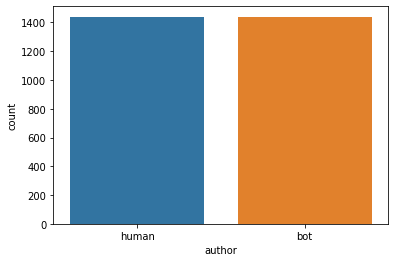

In [9]:
# Human/Bot distribution
# Data distribution is exactly even
print('English distribution')
print(sns.countplot(en_training_div_data.author))

Spanish distribution
AxesSubplot(0.125,0.125;0.775x0.755)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


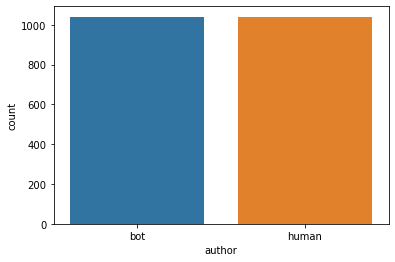

In [9]:
print('Spanish distribution')
print(sns.countplot(es_training_div_data.author))

English distribution


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AxesSubplot(0.125,0.125;0.775x0.755)


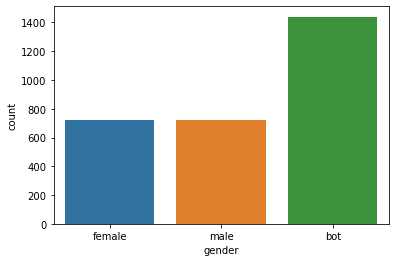

In [10]:
# Gender distribution
# Exactly even for English (bot is 2x as tall)
print('English distribution')
print(sns.countplot(en_training_div_data.gender))

Spanish distribution
AxesSubplot(0.125,0.125;0.775x0.755)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


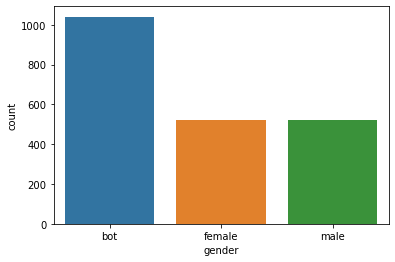

In [11]:
print('Spanish distribution')
print(sns.countplot(es_training_div_data.gender))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Tweet length distribution')

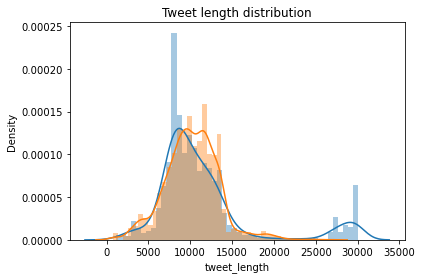

In [12]:
# Tweet length distribution
# Observation: most tweet bodies are between 5000 and 15000 chars
# Spanish (orange) tweets tend to be slightly longer
en_training_div_data['tweet_length'] = en_training_div_data['text'].str.len()
sns.distplot(en_training_div_data['tweet_length']).set_title('Tweet length distribution')
es_training_div_data['tweet_length'] = es_training_div_data['text'].str.len()
sns.distplot(es_training_div_data['tweet_length']).set_title('Tweet length distribution')

### Wordcloud visualizations

In [13]:
def create_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, collocations=False).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

English human common words:


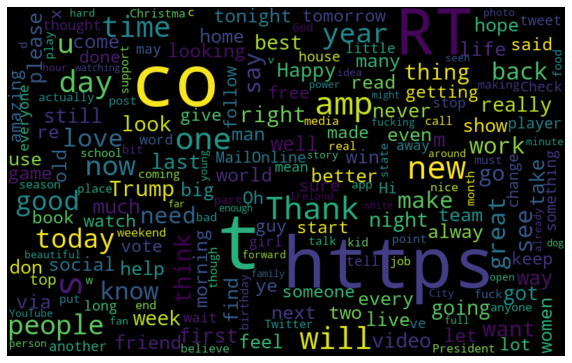

English bot common words:


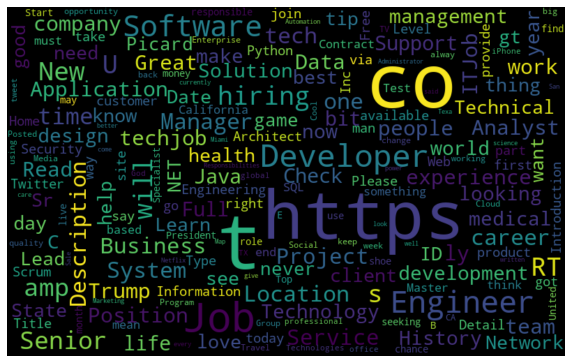

English male common words:


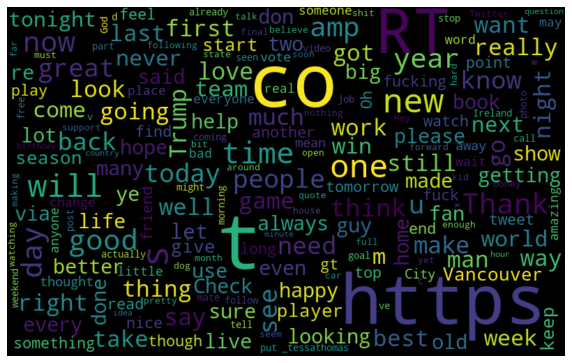

English female common words:


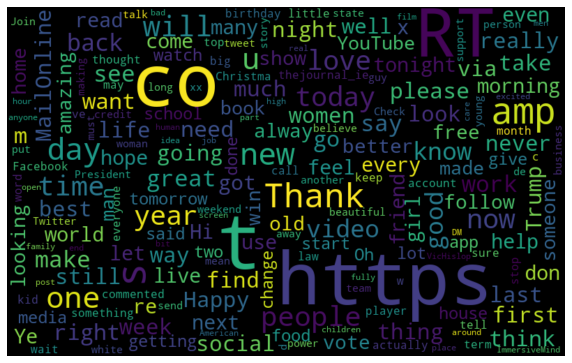

In [74]:
print('English human common words:')
subset=en_training_div_data[en_training_div_data.author=="human"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)

print('English bot common words:')
subset=en_training_div_data[en_training_div_data.author=="bot"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)

print('English male common words:')
subset=en_training_div_data[en_training_div_data.gender=="male"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)

print('English female common words:')
subset=en_training_div_data[en_training_div_data.gender=="female"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)

Spanish human common words:


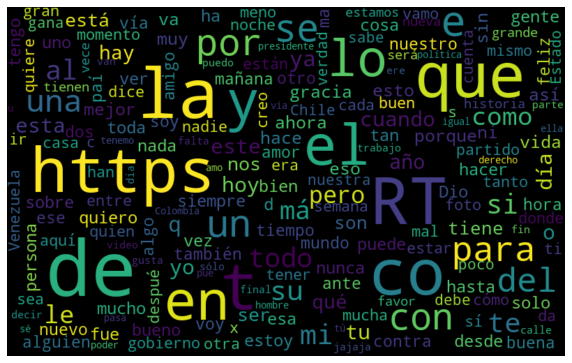

Spanish bot common words:


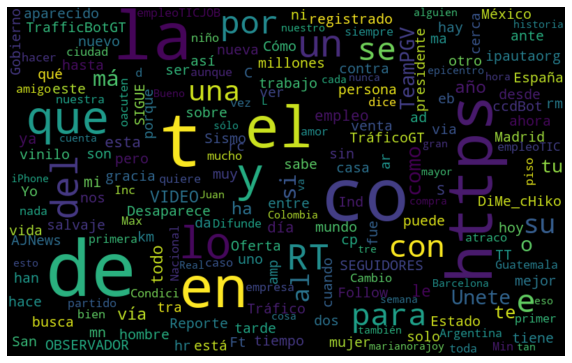

Spanish male common words:


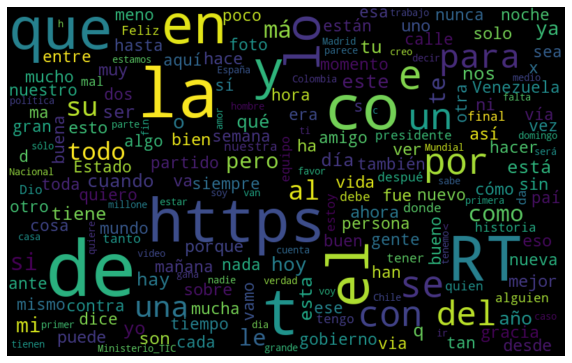

Spanish female common words:


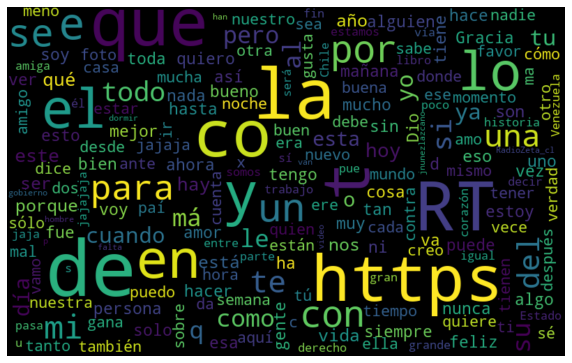

In [75]:
print('Spanish human common words:')
subset=es_training_div_data[es_training_div_data.author=="human"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)

print('Spanish bot common words:')
subset=es_training_div_data[es_training_div_data.author=="bot"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)

print('Spanish male common words:')
subset=es_training_div_data[es_training_div_data.gender=="male"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)

print('Spanish female common words:')
subset=es_training_div_data[es_training_div_data.gender=="female"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)

# Step 2: Preprocessing

### Corpus functions for English and Spanish

In [12]:
# gensim only accepts tokenized lists
# so this preprocesses and coverts tweet-body strings into tokens
def build_tokenized_corpus_en(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        tweet = str(data[i])
        tweet = tweet.lower()

        # Replace certain types of strings with keywords
        tweet = re.sub(r'https?:\/\/.\S*', ' URL ', tweet)  # replace every url with URL
        tweet = re.sub(r'@.\S*', ' MENTION ', tweet)  # replace every mention with MENTION
        tweet = re.sub(r'#.\S*', ' HASHTAG ', tweet)  # replace every hashtag with HASHTAG
        # tweet = re.sub(r'".*"', ' QUOTE ', tweet)  # replace every quote with QUOTE

        # Further tweet sanitation
        tweet = re.sub(r'\s+[a-z]\s+', ' ', tweet)  # remove single characters like i and a
        tweet = re.sub(r'^[a-z]\s+', ' ', tweet)  # remove single characters at the beginning like i and a
        tweet = re.sub(r'\s+', ' ', tweet)  # remove extra spaces

        # lemmatize words
        tweet = word_tokenize(tweet)
        tweet = [w for w in tweet if w not in stop_words_en]
        corpus.append(tweet)
    return corpus

In [7]:
def build_tokenized_corpus_en(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        tweet = str(data[i])
        tweet = tweet.lower()
        # Replace certain types of strings with keywords
        tweet = re.sub(r'https?:\/\/.\S*', ' URL ', tweet)  # replace every url with URL
        tweet = re.sub(r'@.\S*', ' MENTION ', tweet)  # replace every mention with MENTION
        tweet = re.sub(r'#.\S*', ' HASHTAG ', tweet)  # replace every hashtag with HASHTAG
        # Further tweet sanitation
        tweet = re.sub(r'\s+[a-z]\s+', ' ', tweet)  # remove single characters like i and a
        tweet = re.sub(r'^[a-z]\s+', ' ', tweet)  # remove single characters at the beginning like i and a
        tweet = re.sub(r'\s+', ' ', tweet)  # remove extra spaces
        
                # lemmatize words
        tokenizedTweet = en_nlp(tweet)
        # Sentiment analyzer
        analyser = SentimentIntensityAnalyzer()
        score = analyser.polarity_scores(tweet)
        # Convert dictionary into string
        score = str(score) 
        processedTweet = []
        for l in tokenizedTweet:
            processedTweet.append(f"{l.lemma_}({l.pos_})")
        processedTweet.append(score)
        corpus.append(processedTweet)
    return corpus

In [8]:
# Build Spanish corpus
def build_tokenized_corpus_es(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        tweet = str(data[i])
        tweet = tweet.lower()
        
        # Replace certain types of strings with keywords
        tweet = re.sub(r'https?:\/\/.\S*', ' URL ', tweet)  # replace every url with URL
        tweet = re.sub(r'@.\S*', ' MENTION ', tweet)  # replace every mention with MENTION
        tweet = re.sub(r'#.\S*', ' HASHTAG ', tweet)  # replace every hashtag with HASHTAG
        # tweet = re.sub(r'".*"', ' QUOTE ', tweet)  # replace every quote with QUOTE

        tweet = re.sub(r'^[ja]*\s', ' LAUGH', tweet)

        # Further tweet sanitation
        tweet = re.sub(r'\s+[a-z]\s+', ' ', tweet)  # remove single characters like i and a
        tweet = re.sub(r'^[a-z]\s+', ' ', tweet)  # remove single characters at the beginning like i and a
        tweet = re.sub(r'\s+', ' ', tweet)  # remove extra spaces

        # lemmatize words
        tokenizedTweet = es_nlp(tweet)
        # Sentiment analyzer
        analyser = SentimentIntensityAnalyzer()
        score = analyser.polarity_scores(tweet)
        # Convert dictionary into string
        score = str(score) 
        processedTweet = []
        for l in tokenizedTweet:
            processedTweet.append(f"{l.lemma_}({l.pos_})")
        processedTweet.append(score)
        corpus.append(processedTweet)
    return corpus

In [56]:
def build_tokenized_corpus_es(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        tweet = str(data[i])
        tweet = tweet.lower()
        # Replace certain types of strings with keywords
        tweet = re.sub(r'https?:\/\/.\S*', ' URL ', tweet)  # replace every url with URL
        tweet = re.sub(r'@.\S*', ' MENTION ', tweet)  # replace every mention with MENTION
        tweet = re.sub(r'#.\S*', ' HASHTAG ', tweet)  # replace every hashtag with HASHTAG
        # Further tweet sanitation
        tweet = re.sub(r'\s+[a-z]\s+', ' ', tweet)  # remove single characters like i and a
        tweet = re.sub(r'^[a-z]\s+', ' ', tweet)  # remove single characters at the beginning like i and a
        tweet = re.sub(r'\s+', ' ', tweet)  # remove extra spaces

        corpus.append(tweet)
    return corpus

### Build the English and Spanish corpora

In [9]:
# English
processed_train_split_corpus_en = build_tokenized_corpus_en(en_training_div_data['text'])
processed_test_split_corpus_en = build_tokenized_corpus_en(en_testing_div_data['text'])
en_pan_test_corpus = build_tokenized_corpus_en(en_test_X)

In [10]:
# Spanish
processed_train_split_corpus_es = build_tokenized_corpus_es(es_training_div_data['text'])
processed_test_split_corpus_es = build_tokenized_corpus_es(es_testing_div_data['text'])
es_pan_test_corpus = build_tokenized_corpus_es(es_test_X)

### Find the most common words using TF-IDF gensim

In [11]:
def find_most_common_en(processed_train_split_corpus):
    # Create a gensim dictionary
    dictionary = Dictionary(processed_train_split_corpus)
    # Turn the tweets (docs) into BOW
    corpus = [dictionary.doc2bow(doc) for doc in processed_train_split_corpus]
    unwanted_most_common_words = {}
    # Create the defaultdict: total_word_count
    total_word_count = defaultdict(int)
    for word_id, word_count in itertools.chain.from_iterable(corpus):
        total_word_count[word_id] += word_count

    # Create a sorted list from the defaultdict: sorted_word_count 
    sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

    # Find the top 500 words across all documents alongside the count
    for word_id, word_count in sorted_word_count[:100]:
        unwanted_most_common_words[dictionary.get(word_id)] = word_count

    # We need to keep track of the special tags we created in the preprocessing
    # so we just popped them from the 500 list
    unwanted_most_common_words.pop("URL(PROPN)")
    unwanted_most_common_words.pop("MENTION(PROPN)")
    unwanted_most_common_words.pop("HASHTAG(PROPN)")
    #unwanted_most_common_words.pop("QUOTE")
    unwanted_most_common_words.pop("rt(X)")
    
    return list(unwanted_most_common_words.keys())

In [12]:
def find_most_common_es(processed_train_split_corpus):
    # Create a gensim dictionary
    dictionary = Dictionary(processed_train_split_corpus)
    # Turn the tweets (docs) into BOW
    corpus = [dictionary.doc2bow(doc) for doc in processed_train_split_corpus]
    unwanted_most_common_words = {}
    # Create the defaultdict: total_word_count
    total_word_count = defaultdict(int)
    for word_id, word_count in itertools.chain.from_iterable(corpus):
        total_word_count[word_id] += word_count

    # Create a sorted list from the defaultdict: sorted_word_count 
    sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

    # For Spanish, using only the top 100 words worked best
    for word_id, word_count in sorted_word_count[:100]:
        unwanted_most_common_words[dictionary.get(word_id)] = word_count
        
    unwanted_most_common_words.pop("URL(PROPN)")
    unwanted_most_common_words.pop("MENTION(PROPN)")
    unwanted_most_common_words.pop("HASHTAG(PROPN)")
    #unwanted_most_common_words.pop("QUOTE(PROPN)")
    unwanted_most_common_words.pop("rt(CCONJ)")
    
    return list(unwanted_most_common_words.keys())

In [13]:
# English
unwanted_en = find_most_common_en(processed_train_split_corpus_en)

In [14]:
# Spanish
unwanted_es = find_most_common_es(processed_train_split_corpus_es)

### Convert the lists of tokens back to tweet_bodies while deleting all unwanted tokens

In [15]:
def combine_tokens_into_tweets(data):
    corpus = []
    for i in range(0, len(data)):
        tweet = data[i]
        tweet = ' '.join([w for w in tweet])
        corpus.append(tweet)
    return corpus

def remove_words_from_tweets(data, unwanted):
    corpus = []
    for i in range(0, len(data)):
        tweet = data[i].split()
        tweet = ' '.join([w for w in tweet if w not in unwanted])
        corpus.append(tweet)
    return corpus

In [16]:
# English
combined_training_en = combine_tokens_into_tweets(processed_train_split_corpus_en)
combined_testing_en = combine_tokens_into_tweets(processed_test_split_corpus_en)
combined_pan_test_en = combine_tokens_into_tweets(en_pan_test_corpus)
processed_training_corpus_en = remove_words_from_tweets(combined_training_en, unwanted_en)
processed_testing_corpus_en = remove_words_from_tweets(combined_testing_en, unwanted_en)
processed_pan_test_en = remove_words_from_tweets(combined_pan_test_en, unwanted_en)

In [60]:
# English
processed_training_corpus_en = combine_tokens_into_tweets(processed_train_split_corpus_en)
processed_testing_corpus_en = combine_tokens_into_tweets(processed_test_split_corpus_en)
processed_pan_test_en = combine_tokens_into_tweets(en_pan_test_corpus)

In [61]:
# Spanish
processed_training_corpus_es = combine_tokens_into_tweets(processed_train_split_corpus_es)
processed_testing_corpus_es = combine_tokens_into_tweets(processed_test_split_corpus_es)
processed_pan_test_es = combine_tokens_into_tweets(es_pan_test_corpus)

In [17]:
# Spanish
combined_training_es = combine_tokens_into_tweets(processed_train_split_corpus_es)
combined_testing_es = combine_tokens_into_tweets(processed_test_split_corpus_es)
combined_pan_test_es = combine_tokens_into_tweets(es_pan_test_corpus)
processed_training_corpus_es = remove_words_from_tweets(combined_training_es, unwanted_es)
processed_testing_corpus_es = remove_words_from_tweets(combined_testing_es, unwanted_es)
processed_pan_test_es = remove_words_from_tweets(combined_pan_test_es, unwanted_es)

### Convert human/bot and male/female categories to 1/0 for ML use

In [18]:
def set_bot_labels(data):
    labels = []
    for j in range(0, len(data)):
        if data[j] == "human":
            label = 1
        else:
            label = 0
        labels.append(label)
    return labels

def set_gender_labels(data):
    labels = []
    for j in range(0, len(data)):
        if data[j] == "bot":
            label = 0
        elif data[j] == "female":
            label = 1
        else:
            label = 2
        labels.append(label)
    return labels

In [19]:
# English
training_corpus_labels_en = set_bot_labels(en_training_div_data['author'])
testing_corpus_labels_en = set_bot_labels(en_testing_div_data['author'])
en_pan_test_labels = set_bot_labels(en_test_author)

training_corpus_labels_gender_en = set_gender_labels(en_training_div_data['gender'])
testing_corpus_labels_gender_en = set_gender_labels(en_testing_div_data['gender'])
en_pan_test_labels_gender = set_gender_labels(en_test_gender)

In [20]:
# Spanish
training_corpus_labels_es = set_bot_labels(es_training_div_data['author'])
testing_corpus_labels_es = set_bot_labels(es_testing_div_data['author'])
es_pan_test_labels = set_bot_labels(es_test_author)

training_corpus_labels_gender_es = set_gender_labels(es_training_div_data['gender'])
testing_corpus_labels_gender_es = set_gender_labels(es_testing_div_data['gender'])
es_pan_test_labels_gender = set_gender_labels(es_test_gender)

### Wordclouds after preprocessing the data

English human common words:


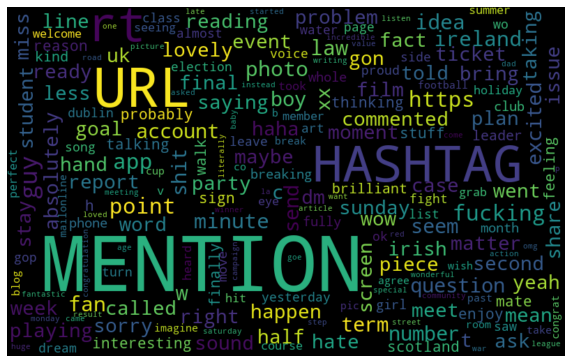

English bot common words:


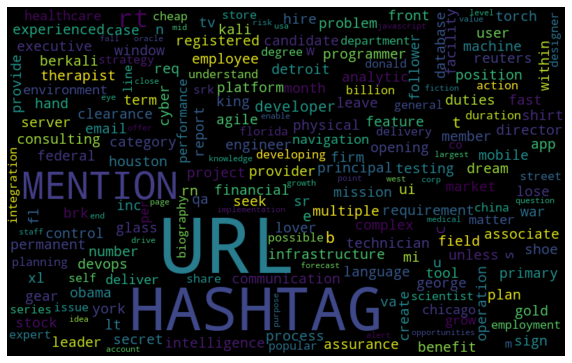

English male common words:


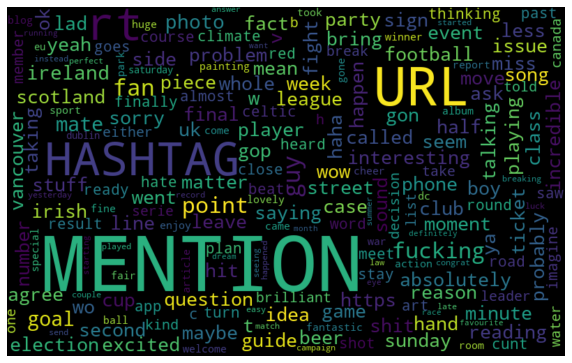

English female common words:


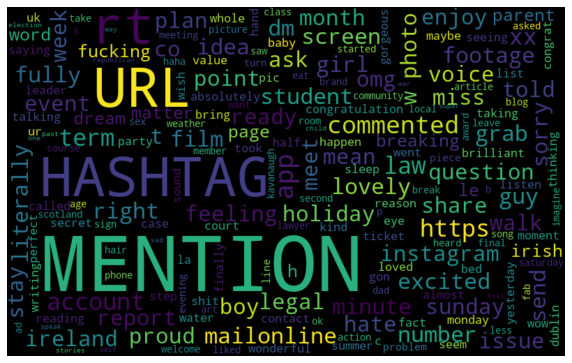

In [77]:
print('English human common words:')
indexes = [i for i in range(0, len(training_corpus_labels_en)) if training_corpus_labels_en[i]==1]
words= ' '.join(np.array(processed_training_corpus_en)[indexes])
create_wordcloud(words)

print('English bot common words:')
indexes = [i for i in range(0, len(training_corpus_labels_en)) if training_corpus_labels_en[i]==0]
words= ' '.join(np.array(processed_training_corpus_en)[indexes])
create_wordcloud(words)

print('English male common words:')
indexes = [i for i in range(0, len(training_corpus_labels_gender_en)) if training_corpus_labels_gender_en[i]==2]
words= ' '.join(np.array(processed_training_corpus_en)[indexes])
create_wordcloud(words)

print('English female common words:')
indexes = [i for i in range(0, len(training_corpus_labels_gender_en)) if training_corpus_labels_gender_en[i]==1]
words= ' '.join(np.array(processed_training_corpus_en)[indexes])
create_wordcloud(words)

Spanish bot common words:


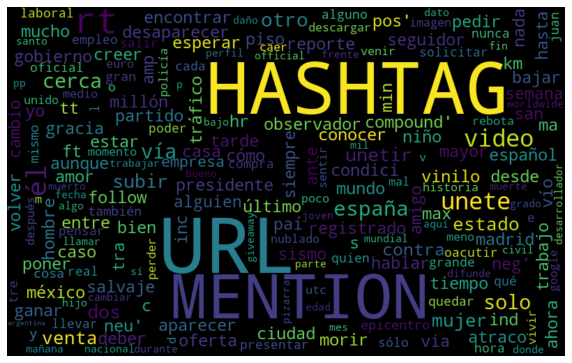

Spanish human common words:


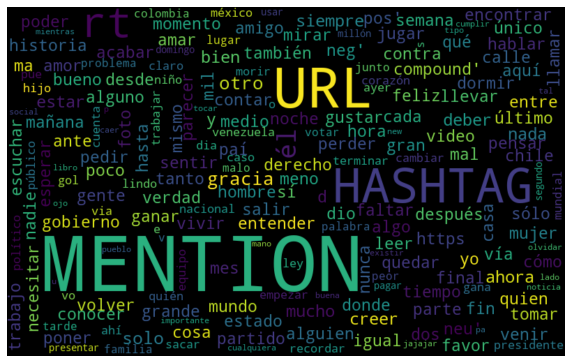

Spanish male common words:


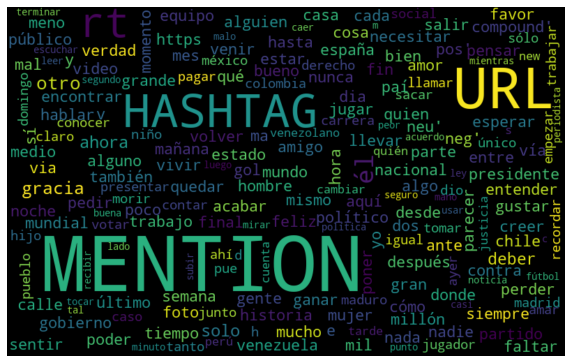

Spanish female common words:


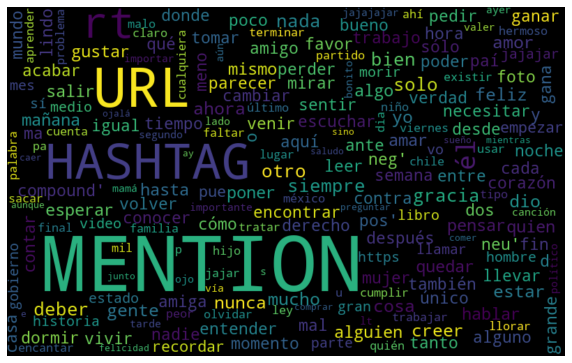

In [78]:
print('Spanish bot common words:')
indexes = [i for i in range(0, len(training_corpus_labels_es)) if training_corpus_labels_es[i]==0]
words = ' '.join(np.array(processed_training_corpus_es)[indexes])
words = re.sub(r"\([^()]*\)", "", words)
create_wordcloud(words)

print('Spanish human common words:')
indexes = [i for i in range(0, len(training_corpus_labels_es)) if training_corpus_labels_es[i]==1]
words = ' '.join(np.array(processed_training_corpus_es)[indexes])
words = re.sub(r"\([^()]*\)", "", words)
create_wordcloud(words)

print('Spanish male common words:')
indexes = [i for i in range(0, len(training_corpus_labels_gender_es)) if training_corpus_labels_gender_es[i]==2]
words= ' '.join(np.array(processed_training_corpus_es)[indexes])
words = re.sub(r"\([^()]*\)", "", words)
create_wordcloud(words)

print('Spanish female common words:')
indexes = [i for i in range(0, len(training_corpus_labels_gender_es)) if training_corpus_labels_gender_es[i]==1]
words= ' '.join(np.array(processed_training_corpus_es)[indexes])
words = re.sub(r"\([^()]*\)", "", words)
create_wordcloud(words)

### Vectorize the tweets

In [21]:
# English
vectorizer_en = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=500, stop_words=stop_words_en)
vectorized_en_training_div_tweets = vectorizer_en.fit_transform(processed_training_corpus_en).toarray()
vectorized_en_testing_div_tweets = vectorizer_en.transform(processed_testing_corpus_en).toarray()
vectorized_en_pan_test_tweets = vectorizer_en.transform(processed_pan_test_en).toarray()

In [22]:
# Spanish
vectorizer_es = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=500, stop_words=stop_words_es)
vectorized_es_training_div_tweets = vectorizer_es.fit_transform(processed_training_corpus_es).toarray()
vectorized_es_testing_div_tweets = vectorizer_es.transform(processed_testing_corpus_es).toarray()
vectorized_es_pan_test_tweets = vectorizer_es.transform(processed_pan_test_es).toarray()

# Step 3: ML Hyperparameter validation testing

### Baseline classifier testing (no hyperparameters)

In [23]:
# English
print('English bot task baselines')
en_ML_model = SVC()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("SVM:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))


en_ML_model = ensemble.RandomForestClassifier()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Random forest:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))

en_ML_model = DecisionTreeClassifier()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Decision Tree:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))

print('\nEnglish gender task baselines')
en_ML_model = SVC()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("SVM:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))


en_ML_model = ensemble.RandomForestClassifier()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Random forest:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))

en_ML_model = DecisionTreeClassifier()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Decision Tree:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))


English bot task baselines
SVM: 0.9094696969696969
Random forest: 0.921969696969697
Decision Tree: 0.8954545454545455

English gender task baselines
SVM: 0.7393939393939394
Random forest: 0.7757575757575758
Decision Tree: 0.6984848484848485


In [24]:
# Spanish
print('Spanish bot task baselines')
es_ML_model = SVC(C=20, kernel='linear')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("SVM:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))

es_ML_model = ensemble.RandomForestClassifier(n_estimators= 200)
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Random forest:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))

es_ML_model = DecisionTreeClassifier(criterion='gini')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Decision Tree:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))


print('\nSpanish gender task baselines')
es_ML_model = SVC()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("SVM:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))

es_ML_model = ensemble.RandomForestClassifier()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Random forest:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))

es_ML_model = DecisionTreeClassifier()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Decision Tree:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))

Spanish bot task baselines
SVM: 0.8922222222222222
Random forest: 0.8861111111111111
Decision Tree: 0.8044444444444444

Spanish gender task baselines
SVM: 0.7138888888888889
Random forest: 0.725
Decision Tree: 0.6616666666666666


### Make a parameter dictionary to apply gridsearchCV on to find the best model for the task

In [25]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': ensemble.RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10, 50, 100, 200, 400, 500, 700]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10, 50, 100]
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {}
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
        }
    }    
}

### Perform gridsearchCV on the parameter dictionary

In [26]:
# English
evaluation_en_human_bot = []
for model_name, mp in model_params.items():
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False )
        clf.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
        evaluation_en_human_bot.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
df = pd.DataFrame(evaluation_en_human_bot, columns=['model', 'best_score', 'best_params'])
print('Best English parameters (bot)')
print(df)

evaluation_en_human_gender = []
for model_name, mp in model_params.items():
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False )
        clf.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
        evaluation_en_human_gender.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
df = pd.DataFrame(evaluation_en_human_gender, columns=['model', 'best_score', 'best_params'])
print('\nBest English parameters (gender)')
print(df)

Best English parameters (bot)
                     model  best_score                    best_params
0                      svm    0.964236  {'C': 20, 'kernel': 'linear'}
1            random_forest    0.967361          {'n_estimators': 100}
2      logistic_regression    0.961458                     {'C': 100}
3     naive_bayes_gaussian    0.868750                             {}
4  naive_bayes_multinomial    0.905903                             {}
5            decision_tree    0.940625          {'criterion': 'gini'}

Best English parameters (gender)
                     model  best_score                    best_params
0                      svm    0.873958  {'C': 20, 'kernel': 'linear'}
1            random_forest    0.904167          {'n_estimators': 700}
2      logistic_regression    0.870139                     {'C': 100}
3     naive_bayes_gaussian    0.742014                             {}
4  naive_bayes_multinomial    0.780556                             {}
5            decision_tree

In [27]:
# Spanish
evaluation_es_human_bot = []
for model_name, mp in model_params.items():
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False )
        clf.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
        evaluation_es_human_bot.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
df = pd.DataFrame(evaluation_es_human_bot, columns=['model', 'best_score', 'best_params'])
print('Best Spanish parameters (bot)')
print(df)

evaluation_es_human_gender = []
for model_name, mp in model_params.items():
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False )
        clf.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
        evaluation_es_human_gender.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
df = pd.DataFrame(evaluation_es_human_gender, columns=['model', 'best_score', 'best_params'])
print('\nBest Spanish parameters (gender)')
print(df)

Best Spanish parameters (bot)
                     model  best_score                    best_params
0                      svm    0.936058  {'C': 20, 'kernel': 'linear'}
1            random_forest    0.939904          {'n_estimators': 200}
2      logistic_regression    0.935096                     {'C': 100}
3     naive_bayes_gaussian    0.678846                             {}
4  naive_bayes_multinomial    0.811058                             {}
5            decision_tree    0.901923          {'criterion': 'gini'}

Best Spanish parameters (gender)
                     model  best_score                    best_params
0                      svm    0.819231  {'C': 20, 'kernel': 'linear'}
1            random_forest    0.842308          {'n_estimators': 700}
2      logistic_regression    0.819231                     {'C': 100}
3     naive_bayes_gaussian    0.526442                             {}
4  naive_bayes_multinomial    0.707692                             {}
5            decision_tree

### Test with the best parameters (must change parameters based on gridsearch results manually)

In [28]:
# English bots
print ('English bot task validation set accuracies')

en_ML_model = SVC(C=20, kernel='linear')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("SVM:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
print("-----------------------------------------")


en_ML_model = ensemble.RandomForestClassifier(n_estimators=400)
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Random forest:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
print("-----------------------------------------")

en_ML_model = GaussianNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Naive Bayes G:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
print("-----------------------------------------")


en_ML_model = MultinomialNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Naive Bayes MN:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
print("-----------------------------------------")


en_ML_model = DecisionTreeClassifier(criterion='gini')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Decision Tree:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))

English bot task validation set accuracies
SVM: 0.8782258064516129
-----------------------------------------
Random forest: 0.9056451612903226
-----------------------------------------
Naive Bayes G: 0.7959677419354839
-----------------------------------------
Naive Bayes MN: 0.8370967741935483
-----------------------------------------
Decision Tree: 0.8887096774193548


In [29]:
# Spanish bots
print('Spanish bot task validation set accuracies')

es_ML_model = SVC(C=20, kernel='linear')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("SVM:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
print("-----------------------------------------")


es_ML_model = ensemble.RandomForestClassifier(n_estimators=200)
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Random forest:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
print("-----------------------------------------")

es_ML_model = GaussianNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Naive Bayes G:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
print("-----------------------------------------")


es_ML_model = MultinomialNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Naive Bayes MN:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
print("-----------------------------------------")


es_ML_model = DecisionTreeClassifier(criterion='gini')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Decision Tree:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_es))

Spanish bot task validation set accuracies
SVM: 0.8804347826086957
-----------------------------------------
Random forest: 0.9010869565217391
-----------------------------------------
Naive Bayes G: 0.6054347826086957
-----------------------------------------
Naive Bayes MN: 0.8336956521739131
-----------------------------------------
Decision Tree: 0.8467391304347827


In [30]:
# English gender
print('English gender task validation set accuracies')

en_ML_model = SVC(C=20, kernel='linear')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("SVM:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),
testing_corpus_labels_gender_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_en))
print("-----------------------------------------")


en_ML_model = ensemble.RandomForestClassifier(n_estimators=700)
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Random forest:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_gender_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_gender_en))
print("-----------------------------------------")

en_ML_model = GaussianNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Naive Bayes G:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_gender_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_gender_en))
print("-----------------------------------------")


en_ML_model = MultinomialNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Naive Bayes MN:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_gender_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_gender_en))
print("-----------------------------------------")


en_ML_model = DecisionTreeClassifier(criterion='gini')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Decision Tree:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_gender_en))
# print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels_gender_en))

English gender task validation set accuracies
SVM: 0.7741935483870968
-----------------------------------------
Random forest: 0.8016129032258065
-----------------------------------------
Naive Bayes G: 0.6056451612903225
-----------------------------------------
Naive Bayes MN: 0.7201612903225807
-----------------------------------------
Decision Tree: 0.6943548387096774


In [31]:
# Spanish gender
print('Spanish gender task validation set accuracies')

es_ML_model = SVC(C=20, kernel='linear')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("SVM:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),
testing_corpus_labels_gender_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))
print("-----------------------------------------")


es_ML_model = ensemble.RandomForestClassifier(n_estimators=200)
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Random forest:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))
print("-----------------------------------------")

es_ML_model = GaussianNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Naive Bayes G:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))
print("-----------------------------------------")


es_ML_model = MultinomialNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Naive Bayes MN:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))
print("-----------------------------------------")


es_ML_model = DecisionTreeClassifier(criterion='gini')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Decision Tree:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))
# print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels_gender_es))

Spanish gender task validation set accuracies
SVM: 0.7152173913043478
-----------------------------------------
Random forest: 0.7315217391304348
-----------------------------------------
Naive Bayes G: 0.375
-----------------------------------------
Naive Bayes MN: 0.658695652173913
-----------------------------------------
Decision Tree: 0.6902173913043478


# Step 4: Final Testing on Test Dataset

## Human vs Bot

In [32]:
# English
en_ML_model = SVC(C=20, kernel='linear')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("SVM:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print("-----------------------------------------")


en_ML_model = ensemble.RandomForestClassifier(n_estimators= 400)
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Random forest:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print("-----------------------------------------")

en_ML_model = GaussianNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Naive Bayes G:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print("-----------------------------------------")


en_ML_model = MultinomialNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Naive Bayes MN:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print("-----------------------------------------")


en_ML_model = DecisionTreeClassifier(criterion='gini')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_en)
print("Decision Tree:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels))

SVM: 0.906060606060606
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1178
           1       0.96      0.87      0.91      1462

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640

-----------------------------------------
Random forest: 0.9227272727272727
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1208
           1       0.97      0.89      0.93      1432

    accuracy                           0.92      2640
   macro avg       0.92      0.93      0.92      2640
weighted avg       0.93      0.92      0.92      2640

-----------------------------------------
Naive Bayes G: 0.7662878787878787
              precision    recall  f1-score   support

           0       0.59      0.92      0.72       845
           1       0.95      0.70      0.80      1795

    acc

In [33]:
# Spanish
es_ML_model = SVC(C=20, kernel='linear')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("SVM:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print("-----------------------------------------")


es_ML_model = ensemble.RandomForestClassifier(n_estimators= 200)
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Random forest:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print("-----------------------------------------")

es_ML_model = GaussianNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Naive Bayes G:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print("-----------------------------------------")


es_ML_model = MultinomialNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Naive Bayes MN:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print("-----------------------------------------")


es_ML_model = DecisionTreeClassifier(criterion='gini')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_es)
print("Decision Tree:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels))

SVM: 0.8922222222222222
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       834
           1       0.93      0.87      0.90       966

    accuracy                           0.89      1800
   macro avg       0.89      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800

-----------------------------------------
Random forest: 0.8872222222222222
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       935
           1       0.87      0.90      0.88       865

    accuracy                           0.89      1800
   macro avg       0.89      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800

-----------------------------------------
Naive Bayes G: 0.6255555555555555
              precision    recall  f1-score   support

           0       0.31      0.85      0.45       324
           1       0.95      0.58      0.72      1476

    ac

## Gender

In [34]:
# English gender
en_ML_model = SVC(C=20, kernel='linear')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("SVM:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print("-----------------------------------------")


en_ML_model = ensemble.RandomForestClassifier(n_estimators=700)
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Random forest:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print("-----------------------------------------")

en_ML_model = GaussianNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Naive Bayes G:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print("-----------------------------------------")


en_ML_model = MultinomialNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Naive Bayes MN:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print("-----------------------------------------")


en_ML_model = DecisionTreeClassifier(criterion='gini')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels_gender_en)
print("Decision Tree:" , accuracy_score(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))
print(classification_report(en_ML_model.predict(vectorized_en_pan_test_tweets),en_pan_test_labels_gender))

SVM: 0.7818181818181819
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1241
           1       0.70      0.66      0.68       698
           2       0.66      0.62      0.64       701

    accuracy                           0.78      2640
   macro avg       0.75      0.74      0.74      2640
weighted avg       0.78      0.78      0.78      2640

-----------------------------------------
Random forest: 0.7886363636363637
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1261
           1       0.69      0.66      0.67       687
           2       0.66      0.63      0.65       692

    accuracy                           0.79      2640
   macro avg       0.75      0.75      0.75      2640
weighted avg       0.78      0.79      0.79      2640

-----------------------------------------
Naive Bayes G: 0.5984848484848485
              precision    recall  f1-score   support

       

In [35]:
# Spanish gender
es_ML_model = SVC(C=20, kernel='linear')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("SVM:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print("-----------------------------------------")


es_ML_model = ensemble.RandomForestClassifier(n_estimators=400)
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Random forest:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print("-----------------------------------------")

es_ML_model = GaussianNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Naive Bayes G:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print("-----------------------------------------")


es_ML_model = MultinomialNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Naive Bayes MN:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print("-----------------------------------------")


es_ML_model = DecisionTreeClassifier(criterion='gini')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels_gender_es)
print("Decision Tree:" , accuracy_score(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))
print(classification_report(es_ML_model.predict(vectorized_es_pan_test_tweets),es_pan_test_labels_gender))

SVM: 0.7077777777777777
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       830
           1       0.46      0.57      0.51       360
           2       0.69      0.51      0.59       610

    accuracy                           0.71      1800
   macro avg       0.66      0.66      0.66      1800
weighted avg       0.71      0.71      0.70      1800

-----------------------------------------
Random forest: 0.7261111111111112
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1038
           1       0.46      0.67      0.54       310
           2       0.58      0.57      0.57       452

    accuracy                           0.73      1800
   macro avg       0.66      0.68      0.66      1800
weighted avg       0.76      0.73      0.74      1800

-----------------------------------------
Naive Bayes G: 0.42
              precision    recall  f1-score   support

           0       0.